Lets try to implement the clutter problem

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps



Lets initiliaze the hyper parameters

In [355]:
w=0.5;
clutter_mean=0;
clutter_var=130;
prior_mean=0;
prior_var=30;
var=1;

Lets generate now the data

In [356]:
n_samples=20
x=np.zeros(n_samples)
#mean=np.random.normal(loc=prior_mean, scale=prior_var)
mean=2
print("the value of the true mean is: ",mean)
for i in range(n_samples):
    coin=np.random.random()
    if coin<w:
        x[i]=np.random.normal(loc=clutter_mean, scale=clutter_var)
    else:
        x[i]=np.random.normal(loc=mean, scale=var)
x;

the value of the true mean is:  2


In [357]:
def calculating_cavities(m_n, v_n, m, v):
    ## m, v are the current estimates of the posterior, 
    ## m_n, v_n are the current ones we wanna update
    ##this creates an indecision form, i have to right it such that it gives no problem 
    #cavity_v = v*v_n/(v_n-v)
    aux = 1/v - 1/v_n
    cavity_v = 1/aux
    cavity_m = m + cavity_v*(m-m_n)/v_n
    return cavity_m, cavity_v

##################################################################################################

def normal_pdf(x, mean, var):
    if var>0:
        norm=(2*np.pi*var)**(1/2)
    else:
        #norm=-1*(-2*np.pi*var)**(1/2)
        #print("i have a negative variance!\n")
        ##it's gonna be negative....not sure is gonna work out
        norm=(2*np.pi)**(1/2)*(-1*np.sqrt(-var))
    exp=np.exp((-0.5/var) * ((x-mean)**2))
    return exp/norm

##################################################################################################

def normalizer(w, x, cavity_m, cavity_v, clutter_var):
    z = (1-w)*normal_pdf(x, cavity_m, cavity_v+1)+w*normal_pdf(x, 0, clutter_var)
    return z

##################################################################################################

def update(w, x, cavity_m, cavity_v, m_n, v_n, clutter_var):
    z = normalizer(w, x, cavity_m, cavity_v, clutter_var)
    ro = 1-w*normal_pdf(x, 0, clutter_var)/z
    
    update_m = cavity_m+ro*(cavity_v/(cavity_v+1))*(x-cavity_m)
    update_v = cavity_v - ro*(cavity_v)**(2)/(cavity_v+1) + ro*(1-ro)*(cavity_v)**(2)*(x-cavity_m)**(2)/((cavity_v+1)**(2))              
    return update_m, update_v

##################################################################################################

def new_marginal(update_m, update_v, cavity_m, cavity_v, z):
    aux=1/update_v-1/cavity_v
    if aux!=0:
        new_v=1/aux
    else:
        ##this remains the same
        new_v=np.inf
    if new_v==np.inf and (1/cavity_v == 0 or update_m==cavity_m):
        new_m=cavity_m
    else:
        new_m=cavity_m+(new_v+cavity_v)/(cavity_v)*(update_m-cavity_m)
    
    denominator=((2*np.pi*new_v)**(1/2)*normal_pdf(new_m, cavity_m, new_v+cavity_v));
    if denominator>0:
        new_s=z/denominator
    else:
        new_s=np.inf
    return new_v, new_m, new_s

##################################################################################################

def convergence(m_old, v_old, s_old, m_new, v_new, s_new, thresh):
    #diff_m=np.abs(m_old-m_new)
    #diff_v=np.abs(v_old, v_new)
    #diff_s=np.abs(s_old, s_new)
    #val=np.max(np.concatenate([diff_m, diff_v, diff_s]))
    val_old=np.concatenate([m_old, v_old, s_old])
    val_new=np.concatenate([m_new, v_new, s_new])
    val=0
    for i in range(len(val_old)):
        if val_old[i]!=np.inf or val_new[i]!=np.inf:
            ##this way i have no form of indecision
            aux=np.abs(val_old[i]-val_new[i])
            if aux>val:
                val=aux
                
    #print("val: ", val)
    if val<thresh:
        return (True, val)
    else:
        return (False, val)



(array([ 1.,  0.,  0.,  0.,  0., 12.,  3.,  0.,  2.,  2.]),
 array([-297.59417975, -246.23402598, -194.87387222, -143.51371845,
         -92.15356469,  -40.79341092,   10.56674284,   61.92689661,
         113.28705037,  164.64720414,  216.00735791]),
 <a list of 10 Patch objects>)

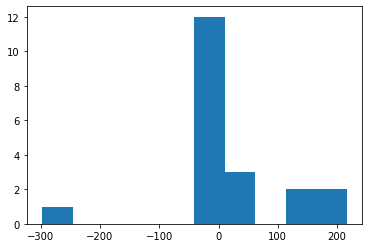

In [358]:
plt.hist(x)

I should make v_n start at infinity, start with a big value and then check how it goes from here

In [359]:
#s_n=(np.zeros(n_samples)+1e9*2*np.pi)**(1/2)
s_n= np.ones(n_samples)
m_n=np.zeros(n_samples)
v_n=np.zeros(n_samples)+np.inf
#v_n=np.zeros(n_samples)+1e6

#s_old=np.copy(s_n)
#v_old=np.copy(v_n)

##i create the prior
m_0=prior_mean
s_0=(2*np.pi*prior_var)**(-1/2)
v_0=prior_var

##i start with the prior as the posterior
m_posterior=m_0
v_posterior=v_0

In [360]:
thresh=1e-9
conv=False
iteration=0
values_convergence=np.zeros(100)
posterior_means=[]
posterior_variance=[]

posterior_means.append(m_posterior)
posterior_variance.append(v_posterior)


while not conv and iteration<100:
    #print("\n");print("i am iter :", iteration);print("\n")
    
    iteration+=1
    m_old=np.copy(m_n)
    v_old=np.copy(v_n)
    s_old=np.copy(s_n)
    ##with s i still have to understand if i have to divide for the normalization constant
    for i in range(len(x)):
        #if i%10==0:
            #print("i am at example: ", i);
        
        #m_old, v_old = m_posterior, v_posterior
        #if iteration==8:
        #print("i is equal to: ", i)
        if i%10==0 and iteration>10000:
        ##i plot now, just for the first iteration to see how it goes
            plt.figure(figsize=(15,10))
            plt.title('i am ad datapoint: '+str(i))
            xs=np.linspace(-10,10,10000)
            ys=normal_pdf(xs, m_posterior, v_posterior)
            plt.plot(xs,ys, color="blue", label="current posterior estimate")
            plt.axvline(x=mean, color="red", label="true generating value")
            aux=x[0:i]
            aux2=np.zeros(len(aux))
            plt.scatter(aux, aux2, marker="*", color="green", s=80, label="realization used")
            plt.legend()
        
        
        if v_n[i]!=v_posterior:
            #print("\nv_n is: ", v_n[i])
            #print("v_posterior: ", v_posterior)
            #print("m_posterior: ", m_posterior)
            cavity_m, cavity_v=calculating_cavities(m_n[i], v_n[i], m_posterior, v_posterior)
            #print("cavity_m: ", cavity_m);print("cavity_v:", cavity_v)
        else:
            #print("skipping i: ", i)
            continue
            
        z=normalizer(w, x[i], cavity_m, cavity_v, clutter_var)
        update_m, update_v = update(w, x[i], cavity_m, cavity_v, m_n[i], v_n[i], clutter_var)
        new_v, new_m, new_s = new_marginal(update_m, update_v, cavity_m, cavity_v, z)
        
        v_n[i]=new_v
        m_n[i]=new_m
        s_n[i]=new_s
        #print("new_w: ", new_v);print("new_m: ", new_m);print("new_s: ", new_s);
        
        m_posterior, v_posterior = update_m , update_v
        posterior_means.append(m_posterior)
        posterior_variance.append(v_posterior)
        
        #if i%10==0:
            #print("mean posterior: ", m_posterior);print("variance posterior: ", v_posterior);print("\n")
        #conv=convergence(m_posterior, v_posterior, m_old, v_old, thresh)
    #if iteration==3:
    #print("i am at iteration: ", iteration)
    #print("m_old: ", m_old);print("m_n: ", m_n);print("\n");print("v_old: ", v_old);print("v_n: ", v_n);print("\n");
    #print("s_old: ", s_old);print("s_n: ", s_n);print("\n")
    ##now i calculate the convergence
    aux=convergence(m_n, v_n, s_n, m_old, v_old, s_old, thresh)
    conv=aux[0]
    values_convergence[iteration-1]=aux[1]
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


I wanna plot now the evolution of the posterior

In [361]:
values_convergence


array([           inf,            inf, 2.46977023e+37, 2.03137231e+37,
       1.08838512e+35, 5.17723004e+32, 1.03782904e+31, 5.36144912e+28,
       2.93798253e+27, 2.46743649e+23, 1.21600937e+23, 2.84217094e-14,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

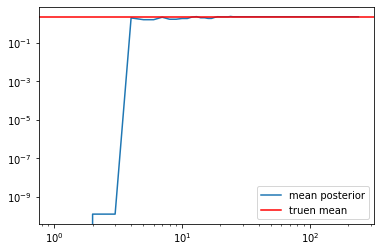

In [362]:
plt.plot(posterior_means, label="mean posterior")
plt.axhline(2, color="red", label="truen mean")
plt.yscale("log")
plt.xscale("log")
plt.legend()

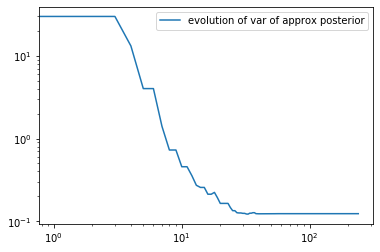

In [363]:
plt.plot(posterior_variance, label="evolution of var of approx posterior")
plt.yscale("log")
plt.xscale("log")
plt.legend()

In [364]:
def unnormalized(x, mu, prior_var, clutter_var, var):
    n=len(x)
    #exponent= -1*(mu*mu)/(2*prior_var) + mu/clutter_var*(sum(x)) - n*mu*mu/(2*clutter_var);
    first=np.exp(-1*(mu*mu)/(2*prior_var))
    res=1;
    for i in range(n):
        factor=(2*np.pi*var)**(-1/2)*np.exp(-0.5*(x[i]-mu)**2) + (2*np.pi*clutter_var)**(-1/2)*np.exp(-x[i]*x[i]/(2*clutter_var))
        res=res*factor
        
    return first*res

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


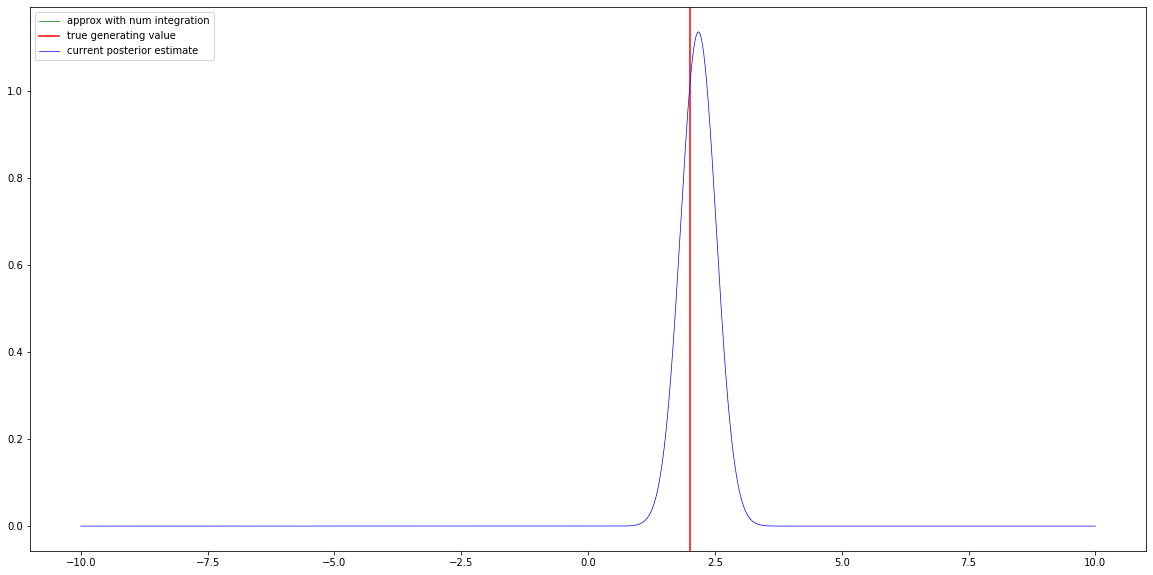

In [365]:
mu=np.linspace(-10,10,10000)
y_mu=np.zeros(10000)
for i in range(10000):
    y_mu[i] = unnormalized(x, mu[i], prior_var, clutter_var, var)
#y_mu=unnormalized(x, mu, prior_var, clutter_var)
normalizer = simps(y_mu, mu)
y_mu_normalized=y_mu/normalizer
ys=normal_pdf(mu, m_posterior, v_posterior)

plt.figure(figsize=(20,10))
plt.plot(mu, y_mu_normalized, color="green", linewidth=0.7, label="approx with num integration")
plt.axvline(x=2, color="red", label="true generating value")
plt.plot(mu,ys, color="blue", linewidth=0.7, label="current posterior estimate")
plt.legend(loc="upper left")
